In [ ]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt


# Extract User_embeding And Save

In [ ]:
'''Select the model file you want to extract userembeding'''
models = ['lgcn'] # 'lgcn', 'ncf' or both
datasets = ['ml-100k', 'ml-1m', 'lfm-2b']
methods = ['original', 'd2d', 'u2u']
attribute = 'gender' # Forgotten attributes, 'gender' in this paper.

In [ ]:
for dataset in datasets:
    for method in methods:
        for model in models:
            weight_path = 'weights'
            target_model_path = f'./exp_results/{model}/{dataset}/{method}/{weight_path}/'
            model_name = 'final_model.pth'
            model = torch.load(target_model_path + model_name, map_location='cpu', weights_only=False)
            user_embeding = model.get_user_embedding_weight()
            np.save(target_model_path + 'user_embeding.npy', user_embeding.detach().numpy())


# Draw The Feature Distribution Map Of User_embeding

In [ ]:
def main(title='', sub_dir='', select_dim=None, model='lgcn'):
    parent_dir = f'./exp_results/{model}/{sub_dir}'
    mat = np.load(f'{parent_dir}/user_embeding.npy')
    if 'ml1m' in title:
        ids = get_gender_id('ml-1m')
    elif 'ml100k' in title:
        ids = get_gender_id('ml-100k')
    elif 'lfm' in title:
        ids = get_gender_id('lfm-2b')
    distribution_plot2(mat, ids, title, select_dim, model)

def get_gender_id(sub_dir):
    user_dict = np.load(f'./data/datasets/{sub_dir}/user_gender.npy', allow_pickle=True).item()
    male_id, female_id = [], []
    for (k, v) in user_dict.items():
        if v == 'M' or v == 'm':
            male_id.append(k)
        else:
            female_id.append(k)
    
    # down-sampling
    np.random.seed(0)
    selected_male_id = np.random.choice(male_id, len(female_id), replace=False)

    return [selected_male_id, female_id]


def distribution_plot2(user_mat, id_lists=[], title='', select_dim='all', model='lgcn'):
    bin, alpha = 50, 0.7
    if select_dim == 'all':
        if model == 'lgcn':
            embeding_range = range(64)
            plt.figure(figsize=(10, 32))
        elif model == 'ncf':
            embeding_range = range(32)
            plt.figure(figsize=(10, 16))
    else:
        embeding_range = select_dim
        plt.figure(figsize=(10, 2))
    for index, i in enumerate(embeding_range):
        edges_dict = {}
        for gender_index, gender in enumerate(['male', 'female']):
            value = user_mat[id_lists[gender_index], i]
            gender_min = min(value)
            gender_max = max(value)
            bins = np.linspace(gender_min, gender_max, 51)
            counts, edges = np.histogram(value, bins)
            edges_min = gender_min
            edges_max = gender_max
            for edge, count in zip(edges, counts):
                if count < 5:
                    edges_min = edge
                else:
                    break
            for edge, count in zip(edges[::-1], counts[::-1]):
                if count < 5:
                    edges_max = edge
                else:
                    break
            edges_dict[gender] = {}
            edges_dict[gender]['min'] = edges_min
            edges_dict[gender]['max'] = edges_max
        low = min(edges_dict['male']['min'], edges_dict['female']['min'])
        high = max(edges_dict['male']['max'], edges_dict['female']['max'])
        if model == 'lgcn':
            plt.subplot(16 if select_dim == 'all' else 1, 4, index+1) 
        elif model == 'ncf':
            plt.subplot(8 if select_dim == 'all' else 1, 4, index+1) 
        plt.hist(user_mat[id_lists[0], i], bin, range=(low,high), alpha=alpha, label='M')
        plt.hist(user_mat[id_lists[1], i], bin, range=(low,high), alpha=alpha, label='F')            
        plt.legend()
    os.makedirs(f'./exp_results/paper/{model}', exist_ok=True)
    plt.savefig(f'./exp_results/paper/{model}/{title}.pdf', bbox_inches='tight')

## ml-1m Dataset Feature Distribution Under "Original", "U2U" and "D2D" Method

In [ ]:
select_dim = [0, 9, 12, 14] # Select the 4 dimension of the feature or select 'all' to display all dimensions.
model = 'lgcn' # 'lgcn' or 'ncf'

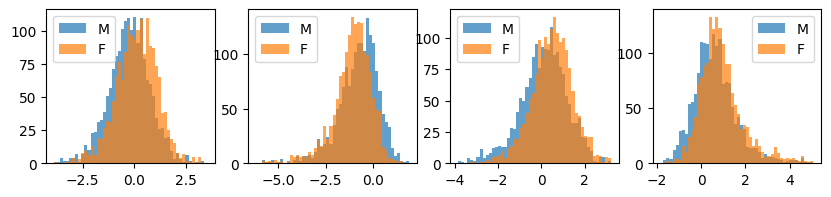

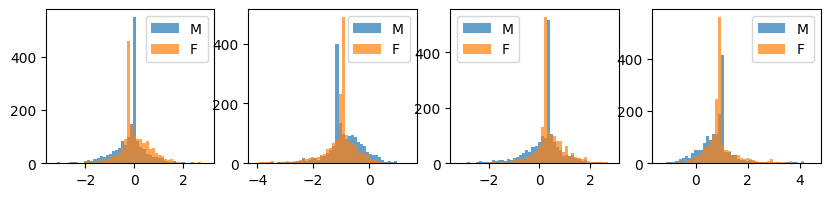

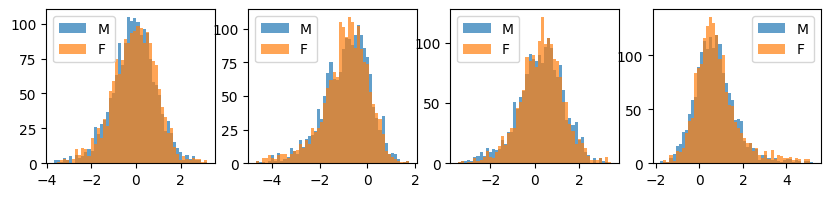

In [ ]:
for method in ['original', 'u2u', 'd2d']:
    main(f'mat_{method}_ml1m', f'ml-1m/{method}/weights', select_dim=select_dim, model=model)

## ml-100k

In [ ]:
select_dim = [33, 12, 17, 26]
model = 'lgcn'

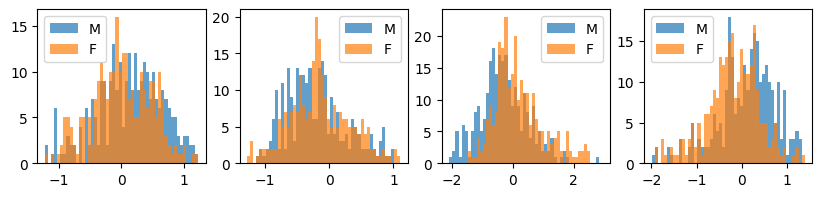

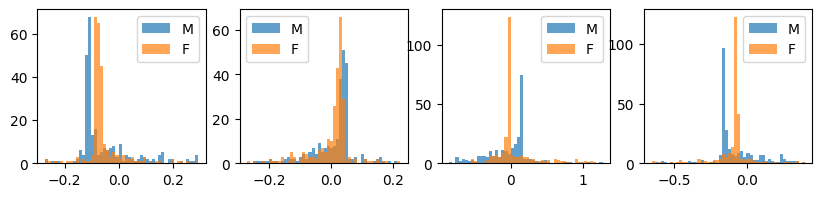

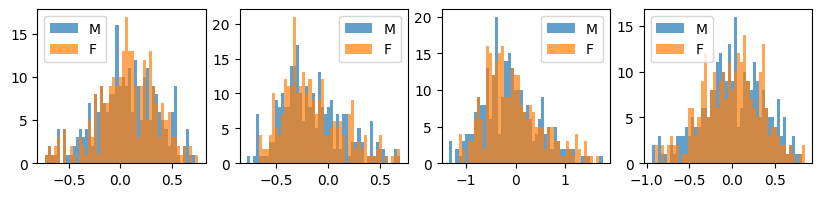

In [ ]:
for method in ['original', 'u2u', 'd2d']:
    main(f'mat_{method}_ml100k', f'ml-100k/{method}/weights', select_dim=select_dim, model=model)

## lfm-2b

In [ ]:
select_dim = [11, 16, 31, 51]
model = 'lgcn'

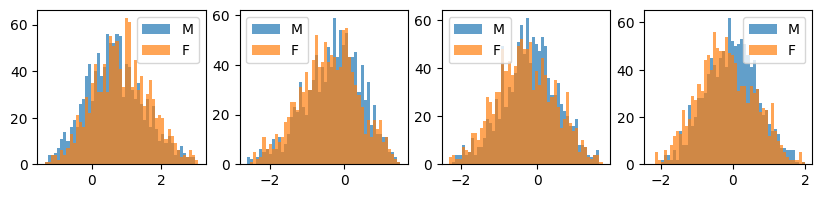

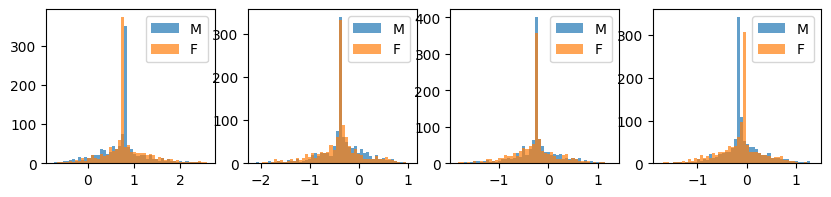

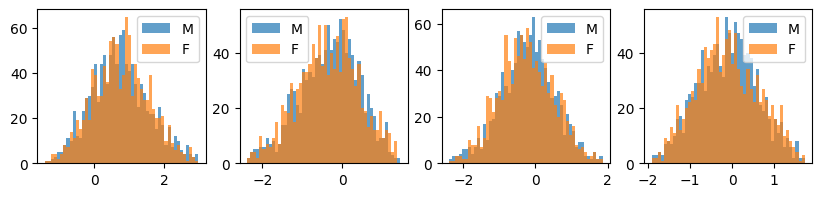

In [ ]:
for method in ['original', 'u2u', 'd2d']:
    main(f'mat_{method}_lfm', f'lfm-2b/{method}/weights', select_dim=select_dim, model=model)